In [ ]:
from matcalc.relaxation import RelaxCalc
from matcalc.phonon import PhononCalc
from matcalc.eos import EOSCalc
from matcalc.elasticity import ElasticityCalc
from matcalc.util import get_universal_calculator
from datetime import datetime
from tqdm import tqdm

from pymatgen.ext.matproj import MPRester

In [ ]:
mpr = MPRester()

/Users/shyue/miniconda3/envs/mavrl/lib/python3.9/site-packages/mp_api/client/mprester.py:182: UserWarning: mpcontribs-client not installed. Install the package to query MPContribs data, or construct pourbaix diagrams: 'pip install mpcontribs-client'
  warnings.warn(


In [ ]:
mp_data = mpr.materials._search(nelements=2, fields=["material_id", "structure"])

Retrieving MaterialsDoc documents:   0%|          | 0/20627 [00:00<?, ?it/s]

In [ ]:
universal_calcs = [(name, get_universal_calculator(name)) for name in ("M3GNet", "CHGNet")]

CHGNet initialized with 400,438 parameters
CHGNet will run on cpu


In [ ]:
fmax = 0.1
opt = "BFGSLineSearch"

In [ ]:
data = []

for d in tqdm(mp_data[:20]):  # Here we just do a sampling of 20 structures.
    s = d.structure
    dd = {"mid": d.material_id, "composition": s.composition.formula, "nsites": len(s)}
    for uc_name, uc in universal_calcs:
        # The general principle is to do a relaxation first and just reuse the same structure.
        prop_calcs = [
            ("relax", RelaxCalc(uc, fmax=fmax, optimizer=opt)),
            ("elastic", ElasticityCalc(uc, fmax=fmax, relax_structure=False)),
            ("eos", EOSCalc(uc, fmax=fmax, relax_structure=False, optimizer=opt)),
            ("phonon", PhononCalc(uc, fmax=fmax, relax_structure=False)),
        ]
        properties = {}
        for name, c in prop_calcs:
            starttime = datetime.now()
            properties[name] = c.calc(s)
            endtime = datetime.now()
            if name == "relax":
                # Replace the structure with the one from relaxation for other property computations.
                s = properties[name]["final_structure"]
            dd[f"time_{name}_{uc_name}"] = (endtime - starttime).total_seconds()
        dd[uc_name] = properties
    data.append(dd)

 60%|████████████████████████████████████████████████████▊                                   | 12/20 [02:31<01:23, 10.47s/it]/Users/shyue/miniconda3/envs/mavrl/lib/python3.9/site-packages/dgl/core.py:82: DGLWarning: The input graph for the user-defined edge function does not contain valid edges
  dgl_warning(
 70%|█████████████████████████████████████████████████████████████▌                          | 14/20 [02:35<00:36,  6.13s/it]/Users/shyue/miniconda3/envs/mavrl/lib/python3.9/site-packages/phonopy/structure/cells.py:1396: UserWarning: Crystal structure is distorted in a tricky way so that phonopy could not handle the crystal symmetry properly. It is recommended to symmetrize crystal structure well and then re-start phonon calculation from scratch.
  warnings.warn(msg)
100%|████████████████████████████████████████████████████████████████████████████████████████| 20/20 [03:34<00:00, 10.75s/it]


In [ ]:
import pandas as pd

df = pd.DataFrame(data)
for uc_name, _ in universal_calcs:
    df[f"time_total_{uc_name}"] = (
        df[f"time_relax_{uc_name}"]
        + df[f"time_elastic_{uc_name}"]
        + df[f"time_phonon_{uc_name}"]
        + df[f"time_eos_{uc_name}"]
    )

In [ ]:
df

,mid,composition,nsites,time_relax_M3GNet,time_elastic_M3GNet,time_eos_M3GNet,time_phonon_M3GNet,M3GNet,time_relax_CHGNet,time_elastic_CHGNet,time_eos_CHGNet,time_phonon_CHGNet,CHGNet,time_total_M3GNet,time_total_CHGNet
0,mp-1106268,Pr14 Pd6,20,5.038833,0.341546,2.877670,18.464435,{'relax': {'final_structure': [[-5.19403841 2...,1.880930,0.175465,0.936000,14.569963,{'relax': {'final_structure': [[-5.17384363 2...,26.722484,17.562358
1,mp-974315,Ru2 I2,4,0.773536,0.179219,1.070539,2.316252,{'relax': {'final_structure': [[ 1.84542095 -1...,1.160128,0.089849,0.437277,2.086802,{'relax': {'final_structure': [[ 1.65819622 -0...,4.339546,3.774056
2,mp-1206714,Al2 Sn1,3,0.167687,0.115795,0.224074,0.234789,{'relax': {'final_structure': [[1.59915279 1.5...,0.079418,0.037410,0.090126,0.148499,{'relax': {'final_structure': [[1.7730046 1.7...,0.742345,0.355453
3,mp-30339,Er1 Ag2,3,0.103580,0.186156,0.595875,0.667356,{'relax': {'final_structure': [[ 8.89873414e-0...,0.099127,0.044774,0.626511,0.447964,{'relax': {'final_structure': [[6.55745455e-08...,1.552967,1.218376
4,mp-696,Si4 Pt4,8,0.884884,0.321063,4.699728,7.904360,{'relax': {'final_structure': [[0.89916847 3.8...,3.056038,0.255416,4.077960,3.434237,{'relax': {'final_structure': [[1.0806827 3.8...,13.810035,10.823651
5,mp-866222,Ac2 Si6,8,3.100128,0.253995,0.823962,6.351784,{'relax': {'final_structure': [[-5.41563953e-0...,0.266855,0.148424,0.597566,5.063765,{'relax': {'final_structure': [[-7.10695448e-0...,10.529869,6.076610
6,mp-11422,Gd1 Hg1,2,0.078004,0.116329,0.168464,0.172210,"{'relax': {'final_structure': [[0. 0. 0.] Gd, ...",0.038391,0.033596,0.055406,0.109223,{'relax': {'final_structure': [[ 1.26072246e-0...,0.535007,0.236616
7,mp-21238,Th4 Si4,8,0.755927,0.203286,1.478711,2.996610,{'relax': {'final_structure': [[1.08960316 0.7...,0.201497,0.103488,1.154557,1.503147,{'relax': {'final_structure': [[1.0389477 0.7...,5.434534,2.962689
8,mp-1215363,Zr4 Pd1,5,0.272751,0.206009,1.201648,2.377837,{'relax': {'final_structure': [[1.68717563e-07...,0.210600,0.124840,0.459993,1.993330,{'relax': {'final_structure': [[1.04751628e-06...,4.058245,2.788763
9,mp-1212658,Ga1 C6,7,0.628700,0.237454,1.295100,3.996263,{'relax': {'final_structure': [[-1.88279105e-0...,1.873289,0.199898,1.064403,4.189688,{'relax': {'final_structure': [[-6.66235219e-0...,6.157517,7.327278


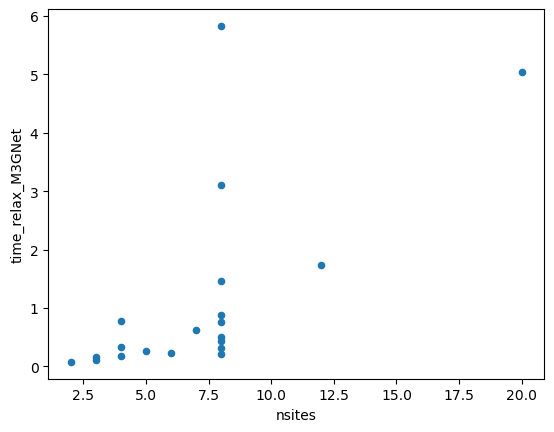

In [ ]:
ax = df.plot(x="nsites", y="time_relax_M3GNet", kind="scatter")

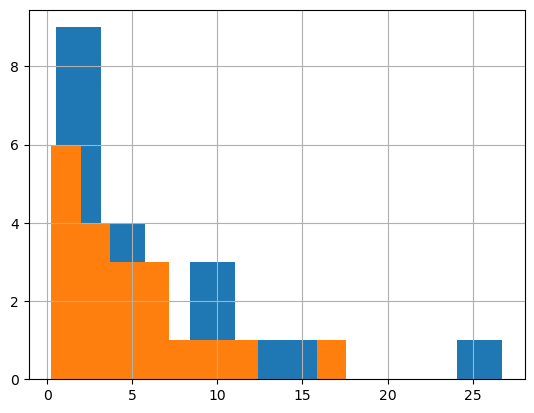

In [ ]:
ax = df["time_total_M3GNet"].hist()
ax = df["time_total_CHGNet"].hist()